In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

import nltk
from nltk.corpus import stopwords
import re

import plotly.express as px
import plotly.graph_objects as go

from copy import deepcopy

# Downloading nltk packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

# Loading Dataset
fake_jobs_raw = pd.read_csv('/content/drive/MyDrive/NMA Deep learning Project/fake_job_postings.csv')
fake_jobs_unprocessed_copy = deepcopy(fake_jobs_raw)
print(fake_jobs_raw.columns)
fake_jobs_raw.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
fake_jobs_unprocessed_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
fake_jobs_unprocessed_copy.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Pre-processing: replace null text entries with white space
text_columns = ['title', 'company_profile', 'location', 'department', 'description', 'requirements', 'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
fake_jobs_raw[text_columns] = fake_jobs_raw[text_columns].fillna(' ') ## Fill wit something like 'not determined'
# Combined text column
fake_jobs_raw['text'] = fake_jobs_raw['title'] + ' ' + fake_jobs_raw['location'] + ' ' + fake_jobs_raw['department'] + ' '+ fake_jobs_raw['company_profile']+' '+fake_jobs_raw['description']+' '+fake_jobs_raw['requirements']+' '+fake_jobs_raw['benefits']+' '+fake_jobs_raw['employment_type'] + ' ' + fake_jobs_raw['required_experience'] + ' '+fake_jobs_raw['required_education'] +' '+ fake_jobs_raw['industry'] + ' '+fake_jobs_raw['function']

# is salary distribution different for fake and real jobs?
def mean_salary_range(salary_range) -> int:
    try:
        lower, upper = salary_range.split("-")
        lower, upper = int(lower), int(upper)
        return (lower + upper) // 2
    except Exception:
        return None


fake_jobs_raw["middle_salary_range"] = fake_jobs_raw["salary_range"].apply(mean_salary_range)

# Remove stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

fake_jobs_raw["text_processed"] = fake_jobs_raw["text"].apply(preprocess_text)

fake = fake_jobs_raw[fake_jobs_raw["fraudulent"] == 1]
real = fake_jobs_raw[fake_jobs_raw["fraudulent"] == 0]


fake_jobs_raw.to_csv("data_processed.csv")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
fake_jobs_raw.to_csv("/content/drive/MyDrive/NMA Deep learning Project/fake_job_postings_processed.csv")

In [ ]:
fake_jobs_raw

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,middle_salary_range,text_processed
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,...,0,Other,Internship,,,Marketing,0,"Marketing Intern US, NY, New York Marketing We...",NaN,marketing intern us ny new york marketing food...
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,"Customer Service - Cloud Video Production NZ, ...",NaN,customer service cloud video production nz auc...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,...,0,,,,,,0,"Commissioning Machinery Assistant (CMA) US, IA...",NaN,commissioning machinery assistant cma us ia we...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,"Account Executive - Washington DC US, DC, Wash...",NaN,account executive washington dc us dc washingt...
4,5,Bill Review Manager,"US, FL, Fort Worth",,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,"Bill Review Manager US, FL, Fort Worth SpotS...",NaN,bill review manager us fl fort worth spotsourc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,...,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,"Account Director - Distribution CA, ON, Toron...",NaN,account director distribution ca toronto sales...
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,"Payroll Accountant US, PA, Philadelphia Accoun...",NaN,payroll accountant us pa philadelphia accounti...
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,...,0,Full-time,,,,,0,Project Cost Control Staff Engineer - Cost Con...,NaN,project cost control staff engineer cost contr...
17878,17879,Graphic Designer,"NG, LA, Lagos",,NaN,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,...,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,"Graphic Designer NG, LA, Lagos Nemsia Stud...",NaN,graphic designer ng la lagos nemsia stu

Fake jobs: 866, Real jobs: 17014, ratio: 0.050899259433407784
4.8434004474272925% of jobs are fraudulent in this dataset


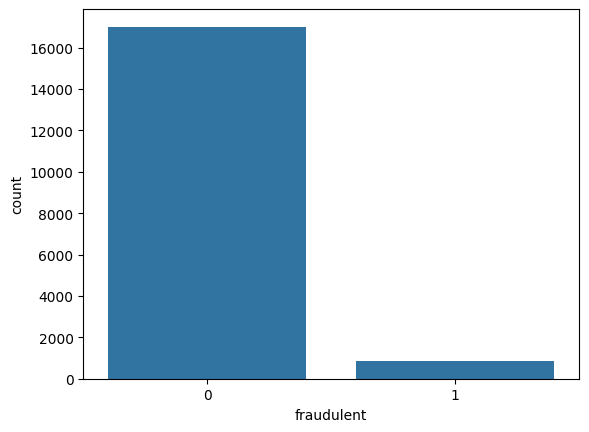

In [ ]:
# Do we have class imbalance
sns.countplot(x = "fraudulent" , data = fake_jobs_raw)

n_fake = len(fake)
n_real = len(real)

print(f"Fake jobs: {n_fake}, Real jobs: {n_real}, ratio: {(n_fake / n_real)}")
print(f"{(n_fake/(n_fake + n_real))*100}% of jobs are fraudulent in this dataset")

# So we do have imbalanced classes
# Issue: model can achieve 95% accuracy by just always outputting 0
# Algorithms for data augmentation? Or: make sure datasets are balanced for the model, OR use oversampling
# See what works best
# Word masking

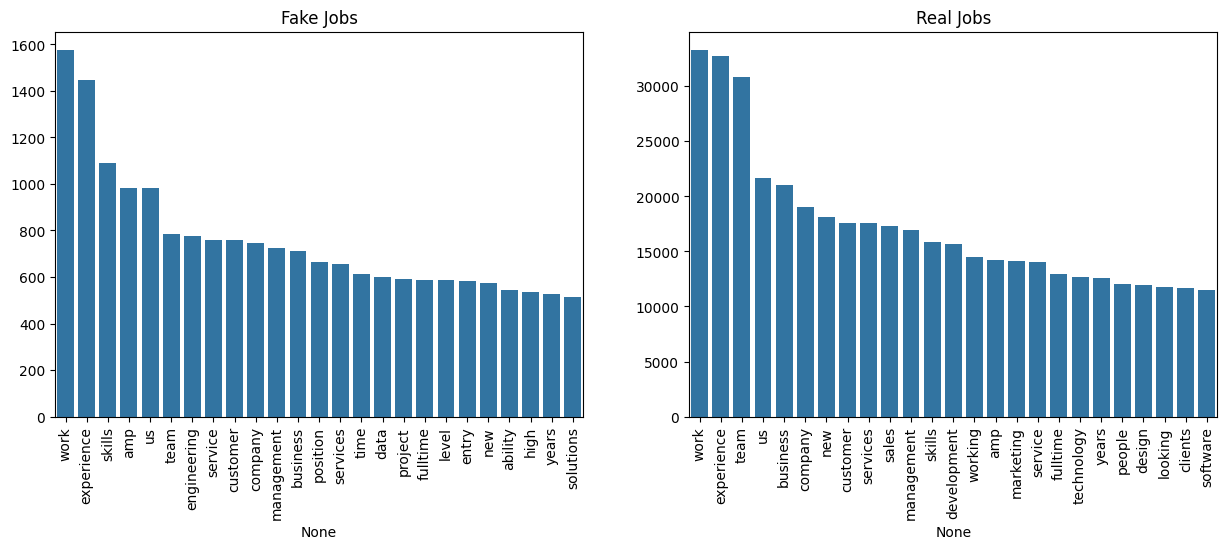

In [ ]:
fake_word_counts = pd.Series(' '.join(fake['text_processed']).split()).value_counts().head(25)
real_word_counts = pd.Series(' '.join(real['text_processed']).split()).value_counts().head(25)

f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=fake_word_counts.index, y=fake_word_counts.values, ax=ax[0])
sns.barplot(x=real_word_counts.index, y=real_word_counts.values, ax=ax[1])

ax[0].set_title('Fake Jobs')
ax[1].set_title('Real Jobs')

for a in ax:
  a.tick_params(axis='x', labelrotation=90)

In [ ]:
only_fake_word_counts = fake_word_counts[~fake_word_counts.index.isin(real_word_counts.index)]
only_real_word_counts = real_word_counts[~real_word_counts.index.isin(fake_word_counts.index)]

print(f"Words only found frequently in fake jobs: {', '.join([word for word in only_fake_word_counts.index])}")
print(f"Words only found frequently in real jobs: {', '.join([word for word in only_real_word_counts.index])}")


Words only found frequently in fake jobs: engineering, position, time, data, project, level, entry, ability, high, solutions
Words only found frequently in real jobs: sales, development, working, marketing, technology, people, design, looking, clients, software


In [ ]:
only_fake_word_counts

,count
engineering,776
position,663
time,612
data,601
project,593
level,587
entry,581
ability,546
high,534
solutions,516


In [ ]:
only_real_word_counts

,count
sales,17262
development,15654
working,14456
marketing,14094
technology,12630
people,12027
design,11956
looking,11758
clients,11654
software,11486


In [ ]:
frequently_found_in_both = fake_word_counts[fake_word_counts.index.isin(real_word_counts.index)]
frequently_found_in_both

,count
work,1576
experience,1445
skills,1092
amp,982
us,982
team,786
service,761
customer,758
company,745
management,723


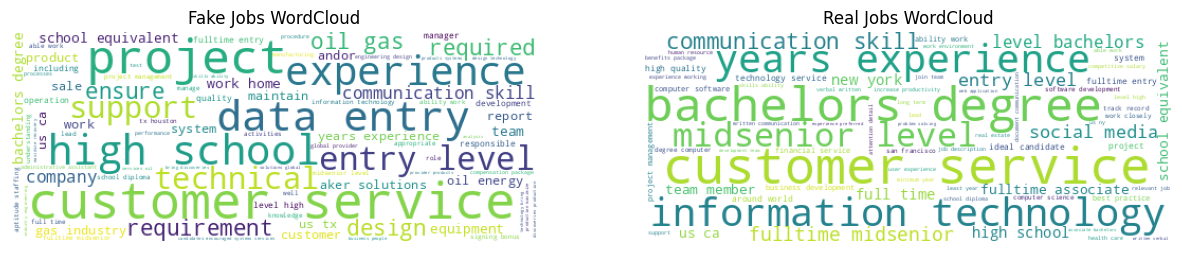

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud(text_series: pd.Series) -> WordCloud:
    return WordCloud(min_font_size=4,width=500, height=200, background_color='white',stopwords=stop_words).generate(' '.join(text_series))

fake_wordcloud = generate_wordcloud(fake["text_processed"])
real_wordcloud = generate_wordcloud(real["text_processed"])

f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(fake_wordcloud)
ax[1].imshow(real_wordcloud)

ax[0].set_title('Fake Jobs WordCloud')
ax[1].set_title('Real Jobs WordCloud')

for a in ax:
  a.axis('off')

job_id: FAKE: 0.00, REAL: 0.00
title: FAKE: 0.00, REAL: 0.00
location: FAKE: 0.00, REAL: 0.00
department: FAKE: 0.00, REAL: 0.00
salary_range: FAKE: 0.74, REAL: 0.84
company_profile: FAKE: 0.00, REAL: 0.00
description: FAKE: 0.00, REAL: 0.00
requirements: FAKE: 0.00, REAL: 0.00
benefits: FAKE: 0.00, REAL: 0.00
telecommuting: FAKE: 0.00, REAL: 0.00
has_company_logo: FAKE: 0.00, REAL: 0.00
has_questions: FAKE: 0.00, REAL: 0.00
employment_type: FAKE: 0.00, REAL: 0.00
required_experience: FAKE: 0.00, REAL: 0.00
required_education: FAKE: 0.00, REAL: 0.00
industry: FAKE: 0.00, REAL: 0.00
function: FAKE: 0.00, REAL: 0.00
fraudulent: FAKE: 0.00, REAL: 0.00
text: FAKE: 0.00, REAL: 0.00
middle_salary_range: FAKE: 0.74, REAL: 0.85
text_processed: FAKE: 0.00, REAL: 0.00


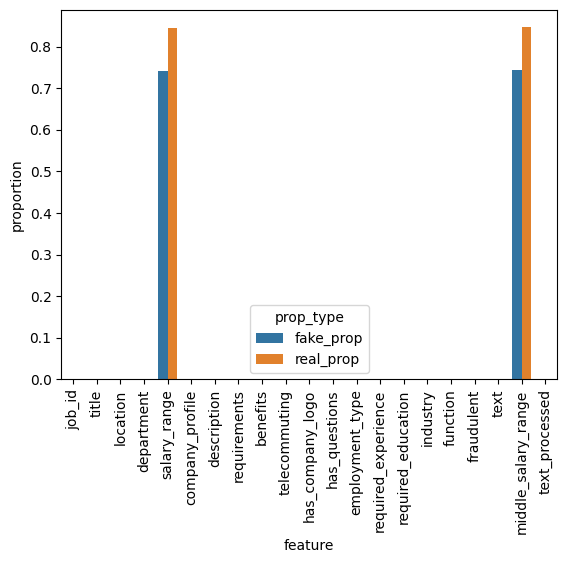

In [ ]:
# Proportion of NA/None entries based on if the job is fraudulent or not
# Tabulate: x-axis: column name, y-axis: proportion

fake_jobs = fake_jobs_raw[fake_jobs_raw["fraudulent"] == 1]
real_jobs = fake_jobs_raw[fake_jobs_raw["fraudulent"] == 0]

table_dict: dict = {
    "feature": [],
    "fake_prop": [],
    "real_prop": []
}

for column in fake_jobs_raw.columns:
    s_fake = fake_jobs[column]
    s_real = real_jobs[column]

    ratio_null_fake = s_fake.isna().sum() / len(s_fake)
    ratio_null_real = s_real.isna().sum() / len(s_real)

    table_dict["feature"].append(column)
    table_dict["fake_prop"].append(ratio_null_fake)
    table_dict["real_prop"].append(ratio_null_real)

    print(f"{column}: FAKE: {ratio_null_fake:.2f}, REAL: {ratio_null_real:.2f}")


prop_na_table = pd.DataFrame(data=table_dict)

melt_tab = prop_na_table.melt(id_vars=['feature'],
                    value_vars=['fake_prop', 'real_prop'],
                    var_name='prop_type',
                    value_name='proportion')

f, ax = plt.subplots()
sns.barplot(data=melt_tab, x='feature', y='proportion', hue='prop_type', ax=ax)
ax.tick_params(axis='x', labelrotation=90)

* Fake jobs seem to have less company profile entries
*

In [ ]:
# EDA questions

In [ ]:
# Possible outside scope of project but can we use NLP to predict salary from some of these features like jbo description

In [ ]:
fake_jobs_raw.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'text', 'middle_salary_range', 'text_processed'],
      dtype='object')

# What features correlate with fraudulent
* Correlation matrix for numerical features
* Simple chi-sq test for categorical

In [ ]:
def chi_sq_test(df, col, target_col):
    contingency_tab = pd.crosstab(df[col], df[target_col])
    chi2, p, df, exp_v = chi2_contingency(contingency_tab)

    return {
        'chi2': chi2,
        'p_value': p,
        'contingency_table': contingency_tab
    }

chi_sq_test(fake_jobs_raw, 'telecommuting', 'fraudulent')['contingency_table']

fraudulent,0,1
telecommuting,,
0,16311,802
1,703,64


<Axes: >

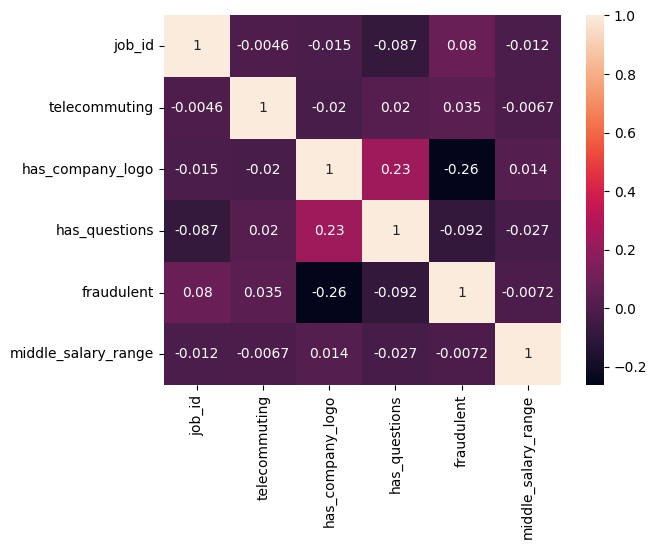

In [ ]:
corr = fake_jobs_raw[["job_id", "telecommuting", "has_company_logo", "has_questions", "fraudulent", "middle_salary_range"]].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), annot=True)

# Numerical variables do not really correlate much with fraudulent

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer()
X = tf_idf.fit_transform(fake_jobs_raw.dropna()["description"])

X.shape

(2841, 21166)

In [ ]:
fake['location'].value_counts().nlargest(10).index.tolist()

['US, TX, Houston',
 'AU, NSW, Sydney',
 'US, , ',
 'US, CA, Bakersfield',
 'US, CA, Los Angeles',
 'US, CA, San Mateo',
 'US, NY, New York',
 ' ',
 'US, TX, AUSTIN',
 'US, CA, San Jose']

Text(0.5, 1.0, 'Real Jobs')

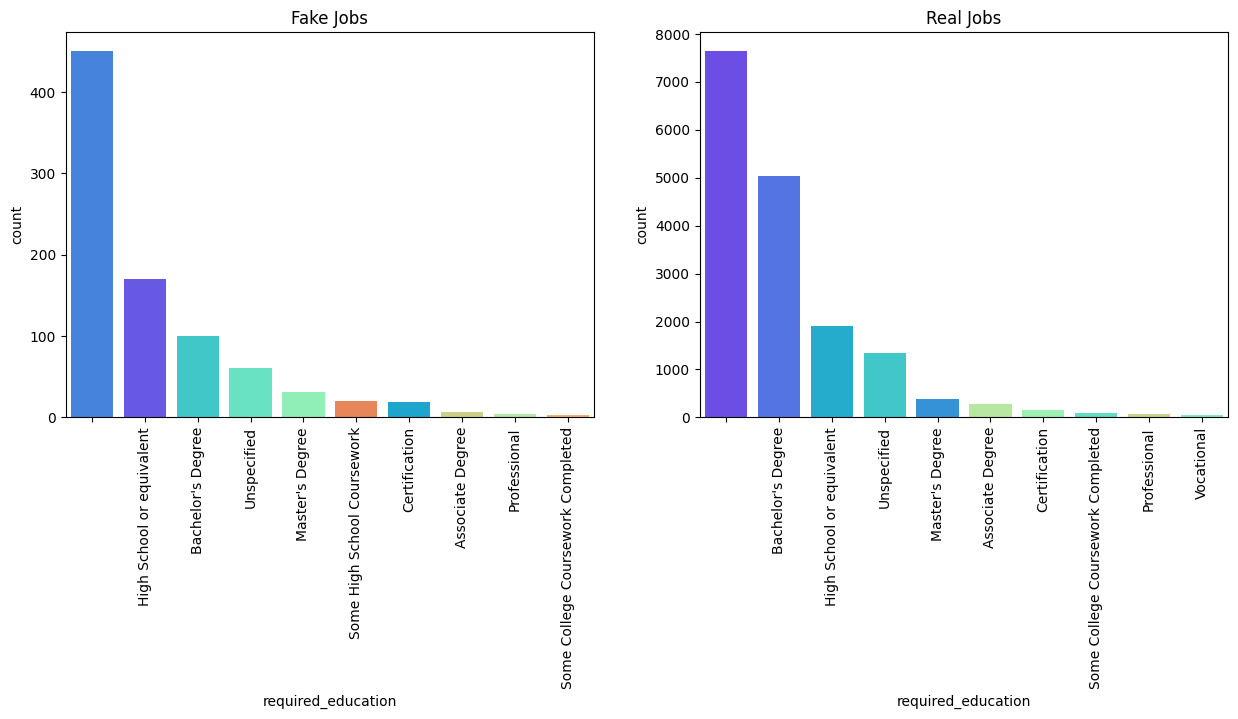

In [ ]:
def generate_countplot(df: pd.DataFrame, column: str, n: int = 10, ax = None):
  counts = df[column].value_counts().nlargest(n).index.tolist()
  if not ax:
    ax = sns.countplot(data=df, x=column, hue=column, legend=False, order=counts, palette='rainbow')
    ax.tick_params(axis='x', labelrotation=90)
  else:
    sns.countplot(data=df, x=column, hue=column, legend=False, order=counts, palette='rainbow', ax=ax)

f, ax = plt.subplots(1, 2, figsize=(15, 5))
generate_countplot(fake, 'required_education', 10, ax[0])
generate_countplot(real, 'required_education', 10, ax[1])

for a in ax:
  a.tick_params(axis='x', labelrotation=90)

ax[0].set_title('Fake Jobs')
ax[1].set_title('Real Jobs')


## What are our Ingredients...
* What parameters / hyperparameters / variables are needed?
    * Constants?
    * Do they change over space, time, conditions…?
    * What details can be omitted?
    * Constraints, initial conditions?
    * Model inputs / outputs?
        * Inputs: Text column? If so, which features should be contributing?
            * Question of data augmentation
            * Which features correlate with fraudulent
        * Outputs: 0 or 1 label
* Variables needed to describe the process to be modelled?
    * Brainstorming!
    * What can be observed / measured? latent variables?
        * Performance of models based on embedding generation method, hyperparameters, etc
            * Hyperparameter gridsearch
            * Regularization
            * Building our own hyperparameters, how?
                * Look for similar task and steal

            * Learning rate, scheduling
            * Optimizer:
                * SGD is more general

        * BERT model for this classification, or LSTM from scratch
    * Where do these variables come from?
    * Do any abstract concepts need to be instantiated as variables?
        * e.g., value, utility, uncertainty, cost, salience, goals, strategy, plant, dynamics
        * Instantiate them so that they relate to potential measurements!


## Addressing the class imbalance
* Oversampling minority class (fraudulent) in the training batches
* Augmentation (ADASYN or SMOTE) on the embeddings (risky, might be semantically invalid)
* Data augmentation using NLP approaches
    * [https://github.com/jasonwei20/eda_nlp](EDA)
    * Back-translation (translate to other language then back)
        * Translation may lead to loss of meaning
* Loss function weighting -- suppose 90/10 class imbalance, penalize incorrect predictions for the minority class by 9x
* Let's try many of these approaches and see what leads to the best performance

* Step 1: Questions and goals
    * Can we infer if job postings are fraudulent based on text features in the job description?
    * How words are distributed accross the dataset?
    * Are certain words characteristic of fake or real job postings?

* Hypothesis:
    * $h(x) = \hat{y} = P(y = 1 | x)$
    * We can train a deep learning NLP model to predict whether a job posting is fraudulent based on its text features


* Toolkits
    * PyTorch
    *


✅ Binary Classification Hypothesis

We want to learn a function:
h(x)=y^=P(y=1∣x)
h(x)=y^​=P(y=1∣x)

Where:

    xx = features extracted from a job posting (text fields: title, description, etc.)

    y∈{0,1}y∈{0,1} where 1 = fake, 0 = real

    y^∈[0,1]y^​∈[0,1] is the predicted probability from the model.

<Axes: xlabel='text_processed', ylabel='Count'>

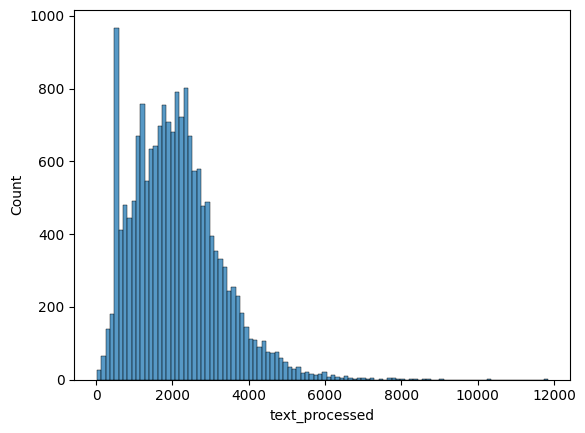

In [ ]:
# Histogram of lengths of text entries
# We do not have fixed size inputs

lengths = fake_jobs_raw['text_processed'].apply(len)
sns.histplot(lengths)